# Imports

In [1]:
from model_builder import ModelBuilder
import random
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import colorsys
from scipy.interpolate import splrep, BSpline # for Spline graphs
from sklearn.linear_model import LinearRegression
from statsmodels.stats.diagnostic import het_white
from statsmodels.tools.tools import add_constant  # Import the add_constant function
import statsmodels.api as sm
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import seaborn as sns
plt.rcParams["font.family"] = "Times New Roman"
import math
import warnings
warnings.filterwarnings("ignore")

In [2]:
with open("config.json", "rb") as json_file:
    config = json.load(json_file)
config

{'becker': {'filename': 'beckerestimation_output_conversation_level.csv',
  'cols_to_ignore': ['conversation_num',
   'mean_pre_discussion_error',
   'mean_post_discussion_error',
   'median_pre_discussion_error',
   'median_post_discussion_error',
   'median_pre_discussion_error_pct',
   'median_post_discussion_error_pct',
   'mean_pre_discussion_error_pct',
   'mean_post_discussion_error_pct',
   'reverse_mean_post_discussion_error_pct',
   'reverse_median_post_discussion_error_pct',
   'question',
   'chatrooms',
   'trial_indx']},
 'csop': {'filename': 'csop_output_conversation_level.csv',
  'cols_to_ignore': ['conversation_num',
   'batch_num',
   'round_num',
   'round_index',
   'task_index',
   'complexity',
   'type',
   'social_perceptiveness',
   'skill',
   'normalized_score',
   'score',
   'duration',
   'efficiency']},
 'csopII': {'filename': 'csopII_output_conversation_level.csv',
  'cols_to_ignore': ['conversation_num',
   'batch_num',
   'vis_img',
   'int_verb',
   '

# Per-Task Linear Models
This notebook contains univariate linear models models to show how different independent variables relate to the dependent variable(s) of interest, for each task.


In [3]:
# For manually fitting and visualizing linear models
sns.set_context("paper", rc={"axes.labelsize":20})
sns.set_context("talk", font_scale=1.4)

def plot_single_linear_model(conversation_data, x_vars, y_vars, num_top_plots=None):
    num_plots = len(x_vars) * len(y_vars)
    num_rows = len(y_vars)
    num_cols = len(x_vars)
    num_plots_per_row = min(5, num_cols)

    num_rows_needed = math.ceil(num_plots / num_plots_per_row)
    fig_height = num_rows_needed * 5
    fig_width = num_plots_per_row * 5

    plt.figure(figsize=(fig_width, fig_height))
    
    plot_num = 1    
    all_metrics = []

    for y_var in y_vars:
        for x_var in x_vars:
            x_data = conversation_data[x_var].values.reshape(-1, 1)
            y_data = conversation_data[y_var].values

            # Fit linear regression model
            model = LinearRegression()
            model.fit(x_data, y_data)

            # Predict using the model
            y_pred = model.predict(x_data)

            # Calculate metrics
            r_squared = r2_score(y_data, y_pred)
            mse = mean_squared_error(y_data, y_pred)
            mae = mean_absolute_error(y_data, y_pred)
            all_metrics.append((x_var, y_var, r_squared, mse, mae))
            
            if num_top_plots is None or plot_num <= num_top_plots:
                plt.subplot(num_rows_needed, num_plots_per_row, plot_num)
                sns.scatterplot(x=x_var, y=y_var, data=conversation_data)
                plt.plot(x_data, y_pred, color='red')
                    
                plot_num += 1
                
                if plot_num > num_plots:
                    break
    
    plt.tight_layout()
    plt.show()
    
    metrics_df = pd.DataFrame(all_metrics, columns=['x_var', 'y_var', 'r_squared', 'mse', 'mae']).sort_values(by='r_squared', ascending=False)
    if num_top_plots is not None:
        metrics_df = metrics_df.head(num_top_plots)

    return(metrics_df)

# Example call
# r2_jury_simple_models = plot_single_linear_model(juries_model.conv, juries_model.conv.drop(["target_raw", "target_std"], axis = 1), ["target_std"], num_top_plots=10)

In [4]:
def convert_metrics_dict_to_sorted_df(data):
    # Convert the nested dictionary to a DataFrame
    df = pd.DataFrame(data).T

    # Reset index to move the 'feature' names to a column
    df.reset_index(inplace=True)
    df.rename(columns={'index': 'feature'}, inplace=True)

    # Sort the DataFrame by 'r2' values in descending order
    df_sorted = df.sort_values(by='r2', ascending=False)

    # Reorder the columns as required
    columns_order = ['feature', 'r2', 'mae', 'mse', 'rmse']
    df_sorted = df_sorted[columns_order]
    return(df_sorted)

In [5]:
def repeated_kfold_cv_simplelinear(model, k = 10, seed = 19104):

    # Store metrics --- R^2, MAE, MSE
    metrics = ['r2', 'mae', 'mse', 'rmse']
    feature_metric_dictionary = {}

    # Assumes that we already called split datasets before we called this function!
    all_features = model.X.columns # include all possible features at this stage

    # set up to store results for this feature
    for feature in all_features:
        feature_metric_dictionary[feature] = {"train": None, "test": None}
        feature_metric_dictionary[feature]["train"] = pd.DataFrame(columns=metrics)
        feature_metric_dictionary[feature]["test"] = pd.DataFrame(columns=metrics)

    # Outer loop --- repeat this k times for k-fold CV
    # Repeated k-fold cross-validation
    random.seed(seed) # set seed for reproducibility
    random_states_list = [random.randint(100, 1000000) for _ in range(k)] # create a bunch of different random states

    for i in range(len(random_states_list)):
        # create an entirely different train-test split for each random iteration
        model.get_split_datasets(model.baseline_model, val_size = 0.2, test_size = None, random_state = random_states_list[i])

        # Save X_train, y_train, X_val, and y_val so that we don't have to split anew every time
        X_train = model.X_train
        X_val = model.X_val
        y_train = model.y_train
        y_val = model.y_val
        
        # Fit a single linear regression on each of the features and report the results
        for feature in model.X_train: # do this only for the features that made it into this split
            # train a linear regression on just this one feature
            evaluation_metrics = model.train_simple_model(model.baseline_model, feature_subset = [feature])
            # store the results for that feature
            feature_metric_dictionary[feature]["train"] = feature_metric_dictionary[feature]["train"].append(evaluation_metrics['train'], ignore_index=True)
            feature_metric_dictionary[feature]["test"] = feature_metric_dictionary[feature]["test"].append(evaluation_metrics['val'], ignore_index=True)
            # reset the train-test-split, as the underlying X_test got modified
            model.set_datasets(X_train=X_train, y_train = y_train, X_val = X_val, y_val = y_val)

    # Get mean metrics for each feature
    '''
    Optimal format:

    feature 1    r2   mae   mse  rmse
    feature 2    r2   mae   mse  rmse
    feature 3    r2   mae   mse  rmse
    '''
    final_feature_metrics_train = {}
    final_feature_metrics_test = {}

    for feature in feature_metric_dictionary.keys():
        final_feature_metrics_train[feature]=feature_metric_dictionary[feature]["train"].mean()
        final_feature_metrics_test[feature]=feature_metric_dictionary[feature]["test"].mean()

    return final_feature_metrics_train, final_feature_metrics_test


In [6]:
# heteroskedasticity?
def get_heteroskedasticity_test(x, y):
    x_with_const = add_constant(x)  # Add a constant term to x
    model = sm.OLS(y, x_with_const).fit()
    #perform White's test
    white_test = het_white(model.resid,  model.model.exog)

    #define labels to use for output of White's test
    labels = ['Test Statistic', 'Test Statistic p-value', 'F-Statistic', 'F-Test p-value']

    #print results of White's test
    return(dict(zip(labels, white_test)))

# Jury

### Full Data (100)%

In [7]:
# Define the basic model
juries_model = ModelBuilder(dataset_names = ["juries"])
juries_model.select_target(target=["majority_pct"])
juries_model.define_model(model_type = 'linear')
juries_model.get_split_datasets(juries_model.baseline_model, val_size = 0.2, test_size = None)

Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done


In [8]:
final_feature_metrics_train,final_feature_metrics_test=repeated_kfold_cv_simplelinear(juries_model)

Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done


In [9]:
jury_train_metrics=convert_metrics_dict_to_sorted_df(final_feature_metrics_train)
jury_test_metrics=convert_metrics_dict_to_sorted_df(final_feature_metrics_test)

In [79]:
estimation_blended_test_metrics[estimation_blended_test_metrics["feature"]=="max_user_avg_info_exchange_zscore_chats"]

,feature,r2,mae,mse,rmse
801,max_user_avg_info_exchange_zscore_chats,-0.18365,0.3162,0.5462,0.7297


In [10]:
jury_train_metrics.head(10).to_csv('./top_features_from_simple_reg/jury_top_10.csv')

In [57]:
jury_test_metrics.head(10).to_csv('./top_features_from_simple_reg/validation/jury_top_10.csv')

In [11]:
jury_test_metrics.head(10)

,feature,r2,mae,mse,rmse
682,average_user_sum_positivity_zscore_chats,0.05382,0.82843,0.90805,0.95205
3,average_positive_bert,0.05127,0.82797,0.91023,0.95289
291,average_positivity_zscore_chats,0.05127,0.82797,0.91023,0.95289
706,average_user_sum_hashedge,0.05048,0.83199,0.91168,0.95403
684,min_user_sum_positivity_zscore_chats,0.04782,0.83173,0.91415,0.95476
593,max_user_sum_verbs,0.0475,0.83777,0.91449,0.95548
714,average_user_sum_hedges,0.04739,0.83457,0.91489,0.95586
717,max_user_sum_hedges,0.04522,0.83664,0.91665,0.95684
590,average_user_sum_verbs,0.04518,0.8339,0.91593,0.95614
709,max_user_sum_hashedge,0.0447,0.83925,0.91687,0.95698


In [12]:
get_heteroskedasticity_test(juries_model.conv["average_user_sum_positivity_zscore_chats"], juries_model.conv["target_std"])

{'Test Statistic': 4.681975318263507,
 'Test Statistic p-value': 0.09623254632587837,
 'F-Statistic': 2.3524565689469936,
 'F-Test p-value': 0.09665955663170653}

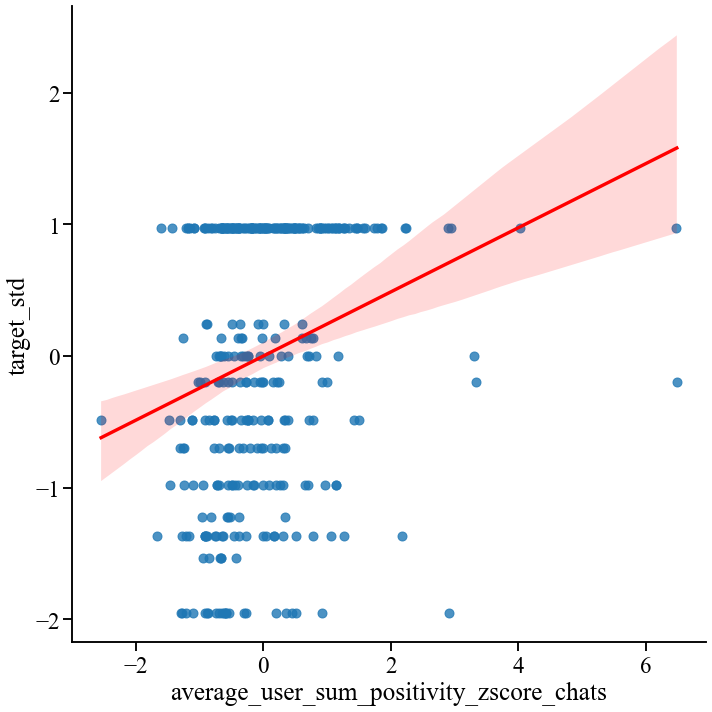

In [13]:
# look at some correlations
sns.lmplot(juries_model.conv, x = "average_user_sum_positivity_zscore_chats", y = "target_std", line_kws={'color': 'red'}, height = 10)
plt.savefig('./figures/juries_average_user_sum_positivity_zscore_chats_lmplot.svg')

### 75% of Data

In [14]:
juries_model75 = ModelBuilder(dataset_names = ["juries"], output_dir = '../output/first_75/')
juries_model75.select_target(target=["majority_pct"])
juries_model75.define_model(model_type = 'linear')
juries_model75.get_split_datasets(juries_model75.baseline_model, val_size = 0.2, test_size = None)

final_feature_metrics_train,final_feature_metrics_test=repeated_kfold_cv_simplelinear(juries_model75)
jury_train_metrics75=convert_metrics_dict_to_sorted_df(final_feature_metrics_train)
jury_test_metrics75=convert_metrics_dict_to_sorted_df(final_feature_metrics_test)

jury_test_metrics75.head(10)

Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done


,feature,r2,mae,mse,rmse
682,average_user_sum_positivity_zscore_chats,0.05382,0.82843,0.90805,0.95205
706,average_user_sum_hashedge,0.05048,0.83199,0.91168,0.95403
684,min_user_sum_positivity_zscore_chats,0.04782,0.83173,0.91415,0.95476
593,max_user_sum_verbs,0.0475,0.83777,0.91449,0.95548
714,average_user_sum_hedges,0.04739,0.83457,0.91489,0.95586
717,max_user_sum_hedges,0.04522,0.83664,0.91665,0.95684
590,average_user_sum_verbs,0.04518,0.8339,0.91593,0.95614
709,max_user_sum_hashedge,0.0447,0.83925,0.91687,0.95698
610,average_user_sum_cognitive_mech,0.04279,0.83487,0.9195,0.95805
546,average_user_sum_social,0.04209,0.83727,0.91865,0.95777


In [15]:
jury_train_metrics75.head(10).to_csv('./top_features_from_simple_reg/jury75_top_10.csv')

In [58]:
jury_test_metrics75.head(10).to_csv('./top_features_from_simple_reg/validation/jury75_top_10.csv')

### 50% Data

In [16]:
juries_model50 = ModelBuilder(dataset_names = ["juries"], output_dir = '../output/first_50/')
juries_model50.select_target(target=["majority_pct"])
juries_model50.define_model(model_type = 'linear')
juries_model50.get_split_datasets(juries_model50.baseline_model, val_size = 0.2, test_size = None)

final_feature_metrics_train,final_feature_metrics_test=repeated_kfold_cv_simplelinear(juries_model50)
jury_train_metrics50=convert_metrics_dict_to_sorted_df(final_feature_metrics_train)
jury_test_metrics50=convert_metrics_dict_to_sorted_df(final_feature_metrics_test)

jury_test_metrics50.head(10)

Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done


,feature,r2,mae,mse,rmse
682,average_user_sum_positivity_zscore_chats,0.05382,0.82843,0.90805,0.95205
706,average_user_sum_hashedge,0.05048,0.83199,0.91168,0.95403
684,min_user_sum_positivity_zscore_chats,0.04782,0.83173,0.91415,0.95476
593,max_user_sum_verbs,0.0475,0.83777,0.91449,0.95548
714,average_user_sum_hedges,0.04739,0.83457,0.91489,0.95586
717,max_user_sum_hedges,0.04522,0.83664,0.91665,0.95684
590,average_user_sum_verbs,0.04518,0.8339,0.91593,0.95614
709,max_user_sum_hashedge,0.0447,0.83925,0.91687,0.95698
610,average_user_sum_cognitive_mech,0.04279,0.83487,0.9195,0.95805
546,average_user_sum_social,0.04209,0.83727,0.91865,0.95777


In [17]:
jury_train_metrics50.head(10).to_csv('./top_features_from_simple_reg/jury50_top_10.csv')

In [59]:
jury_test_metrics50.head(10).to_csv('./top_features_from_simple_reg/validation/jury50_top_10.csv')

### 25% of Data

In [18]:
juries_model25 = ModelBuilder(dataset_names = ["juries"], output_dir = '../output/first_25/')
juries_model25.select_target(target=["majority_pct"])
juries_model25.define_model(model_type = 'linear')
juries_model25.get_split_datasets(juries_model25.baseline_model, val_size = 0.2, test_size = None)

final_feature_metrics_train,final_feature_metrics_test=repeated_kfold_cv_simplelinear(juries_model25)
jury_train_metrics25=convert_metrics_dict_to_sorted_df(final_feature_metrics_train)
jury_test_metrics25=convert_metrics_dict_to_sorted_df(final_feature_metrics_test)

jury_test_metrics25.head(10)

Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done


,feature,r2,mae,mse,rmse
682,average_user_sum_positivity_zscore_chats,0.05382,0.82843,0.90805,0.95205
706,average_user_sum_hashedge,0.05048,0.83199,0.91168,0.95403
684,min_user_sum_positivity_zscore_chats,0.04782,0.83173,0.91415,0.95476
593,max_user_sum_verbs,0.0475,0.83777,0.91449,0.95548
714,average_user_sum_hedges,0.04739,0.83457,0.91489,0.95586
717,max_user_sum_hedges,0.04522,0.83664,0.91665,0.95684
590,average_user_sum_verbs,0.04518,0.8339,0.91593,0.95614
709,max_user_sum_hashedge,0.0447,0.83925,0.91687,0.95698
610,average_user_sum_cognitive_mech,0.04279,0.83487,0.9195,0.95805
546,average_user_sum_social,0.04209,0.83727,0.91865,0.95777


In [19]:
jury_train_metrics25.head(10).to_csv('./top_features_from_simple_reg/jury25_top_10.csv')

In [60]:
jury_test_metrics25.head(10).to_csv('./top_features_from_simple_reg/validation/jury25_top_10.csv')

# CSOP (blended)

### Full Data (100%)

In [20]:
csop_blended_model = ModelBuilder(dataset_names = ["csop", "csopII"])
csop_blended_model.select_target(target=["efficiency", "efficiency"])
csop_blended_model.define_model(model_type = 'linear')
csop_blended_model.get_split_datasets(csop_blended_model.baseline_model, val_size = 0.2, test_size = None)

Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done


In [21]:
final_feature_metrics_train,final_feature_metrics_test=repeated_kfold_cv_simplelinear(csop_blended_model)
csop_blended_train_metrics=convert_metrics_dict_to_sorted_df(final_feature_metrics_train)
csop_blended_test_metrics=convert_metrics_dict_to_sorted_df(final_feature_metrics_test)

csop_blended_test_metrics.head(10)

Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done


,feature,r2,mae,mse,rmse
30,max_info_exchange_zscore_chats,0.04831,0.73354,0.91995,0.95742
22,max_num_chars,0.04829,0.73322,0.92003,0.95743
18,max_num_words,0.04757,0.73392,0.92062,0.95777
20,stdev_num_chars,0.04635,0.73411,0.92182,0.95838
28,stdev_info_exchange_zscore_chats,0.04634,0.73313,0.92177,0.95838
16,stdev_num_words,0.04563,0.73325,0.92244,0.95874
250,max_nltk_english_stopwords,0.04547,0.73636,0.92241,0.95875
240,stdev_positive_words,0.04244,0.73673,0.92621,0.96051
248,stdev_nltk_english_stopwords,0.04134,0.73649,0.92623,0.9608
202,max_verbs,0.04113,0.73754,0.92638,0.9609


In [22]:
csop_blended_train_metrics.head(10).to_csv('./top_features_from_simple_reg/csop_top_10.csv')

In [65]:
csop_blended_test_metrics.head(10).to_csv('./top_features_from_simple_reg/validation/csop_top_10.csv')

In [61]:
get_heteroskedasticity_test(csop_blended_model.conv["average_user_sum_num_words"], csop_blended_model.conv["target_std"])

{'Test Statistic': 27.582233249443284,
 'Test Statistic p-value': 1.024693899383808e-06,
 'F-Statistic': 13.968202552112851,
 'F-Test p-value': 9.483574502343425e-07}

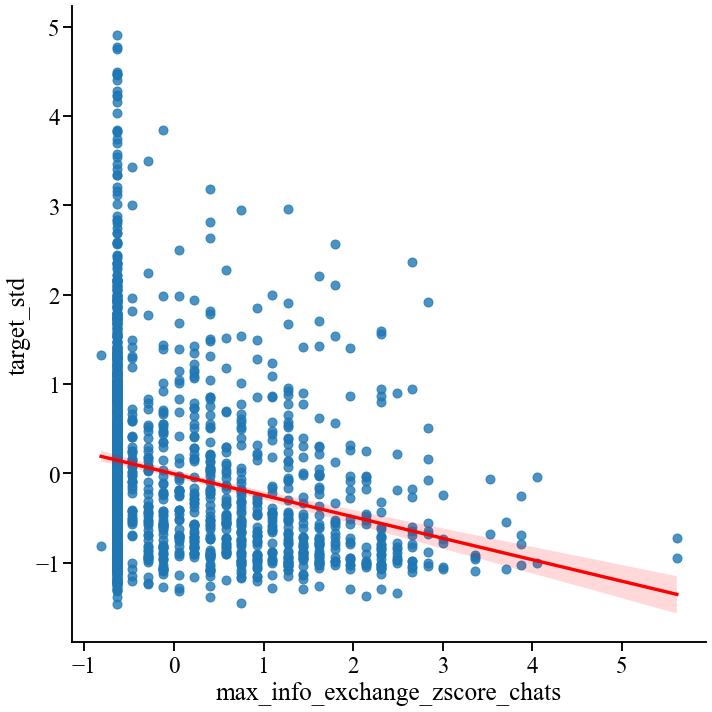

In [52]:
# look at some correlations
sns.lmplot(csop_blended_model.conv, x = "max_info_exchange_zscore_chats", y = "target_std", line_kws={'color': 'red'}, height = 10)
plt.savefig('./figures/csop_max_info_exchange_zscore_chats_lmplot.svg')

In [25]:
#plot_single_linear_model(csop_blended_model.conv, csop_blended_model.conv.drop(["target_raw", "target_std"], axis = 1), ["target_std"], num_top_plots=20)

### 75% Data

In [26]:
csop_blended_model75 = ModelBuilder(dataset_names = ["csop", "csopII"], output_dir = '../output/first_75/')
csop_blended_model75.select_target(target=["efficiency", "efficiency"])
csop_blended_model75.define_model(model_type = 'linear')
csop_blended_model75.get_split_datasets(csop_blended_model75.baseline_model, val_size = 0.2, test_size = None)

final_feature_metrics_train,final_feature_metrics_test=repeated_kfold_cv_simplelinear(csop_blended_model75)
csop_blended_train_metrics75=convert_metrics_dict_to_sorted_df(final_feature_metrics_train)
csop_blended_test_metrics75=convert_metrics_dict_to_sorted_df(final_feature_metrics_test)

csop_blended_test_metrics75.head(10)

Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done


,feature,r2,mae,mse,rmse
22,max_num_chars,0.04684,0.73435,0.92139,0.95815
30,max_info_exchange_zscore_chats,0.04621,0.73498,0.92193,0.95844
18,max_num_words,0.04589,0.73516,0.92222,0.95861
20,stdev_num_chars,0.0429,0.73597,0.92516,0.96014
250,max_nltk_english_stopwords,0.04271,0.73848,0.92516,0.96016
28,stdev_info_exchange_zscore_chats,0.04264,0.73529,0.92526,0.96022
16,stdev_num_words,0.04213,0.73544,0.92573,0.96046
801,max_user_avg_info_exchange_zscore_chats,0.04076,0.7403,0.92711,0.96118
202,max_verbs,0.04033,0.73974,0.92713,0.96128
240,stdev_positive_words,0.04024,0.73837,0.92833,0.96161


In [27]:
csop_blended_train_metrics75.head(10).to_csv('./top_features_from_simple_reg/csop75_top_10.csv')

In [62]:
csop_blended_test_metrics75.head(10).to_csv('./top_features_from_simple_reg/validation/csop75_top_10.csv')

### 50% Data

In [28]:
csop_blended_model50 = ModelBuilder(dataset_names = ["csop", "csopII"], output_dir = '../output/first_50/')
csop_blended_model50.select_target(target=["efficiency", "efficiency"])
csop_blended_model50.define_model(model_type = 'linear')
csop_blended_model50.get_split_datasets(csop_blended_model50.baseline_model, val_size = 0.2, test_size = None)

final_feature_metrics_train,final_feature_metrics_test=repeated_kfold_cv_simplelinear(csop_blended_model50)
csop_blended_train_metrics50=convert_metrics_dict_to_sorted_df(final_feature_metrics_train)
csop_blended_test_metrics50=convert_metrics_dict_to_sorted_df(final_feature_metrics_test)

csop_blended_test_metrics50.head(10)

Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done


,feature,r2,mae,mse,rmse
22,max_num_chars,0.04574,0.73415,0.92282,0.95881
18,max_num_words,0.04341,0.73538,0.92494,0.95994
30,max_info_exchange_zscore_chats,0.04286,0.73516,0.92546,0.96021
801,max_user_avg_info_exchange_zscore_chats,0.04076,0.7403,0.92711,0.96118
793,max_user_avg_num_chars,0.03998,0.74103,0.92794,0.96159
789,max_user_avg_num_words,0.0397,0.74062,0.92811,0.96168
250,max_nltk_english_stopwords,0.03962,0.73922,0.92846,0.9618
202,max_verbs,0.03907,0.74209,0.9289,0.96207
790,average_user_avg_num_chars,0.03869,0.73879,0.92913,0.96221
1021,max_user_avg_nltk_english_stopwords,0.03759,0.74285,0.92995,0.9627


In [29]:
csop_blended_train_metrics50.head(10).to_csv('./top_features_from_simple_reg/csop50_top_10.csv')

In [63]:
csop_blended_test_metrics50.head(10).to_csv('./top_features_from_simple_reg/validation/csop50_top_10.csv')

### 25% Data

In [30]:
csop_blended_model25 = ModelBuilder(dataset_names = ["csop", "csopII"], output_dir = '../output/first_25/')
csop_blended_model25.select_target(target=["efficiency", "efficiency"])
csop_blended_model25.define_model(model_type = 'linear')
csop_blended_model25.get_split_datasets(csop_blended_model25.baseline_model, val_size = 0.2, test_size = None)

final_feature_metrics_train,final_feature_metrics_test=repeated_kfold_cv_simplelinear(csop_blended_model25)
csop_blended_train_metrics25=convert_metrics_dict_to_sorted_df(final_feature_metrics_train)
csop_blended_test_metrics25=convert_metrics_dict_to_sorted_df(final_feature_metrics_test)

csop_blended_test_metrics25.head(10)

Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done


,feature,r2,mae,mse,rmse
801,max_user_avg_info_exchange_zscore_chats,0.04076,0.7403,0.92711,0.96118
793,max_user_avg_num_chars,0.03998,0.74103,0.92794,0.96159
789,max_user_avg_num_words,0.0397,0.74062,0.92811,0.96168
790,average_user_avg_num_chars,0.03869,0.73879,0.92913,0.96221
1021,max_user_avg_nltk_english_stopwords,0.03759,0.74285,0.92995,0.9627
786,average_user_avg_num_words,0.03729,0.73941,0.93039,0.96288
798,average_user_avg_info_exchange_zscore_chats,0.03713,0.73959,0.93059,0.96296
22,max_num_chars,0.03673,0.73997,0.9314,0.96328
1018,average_user_avg_nltk_english_stopwords,0.03669,0.74198,0.93077,0.96311
546,average_user_sum_indefinite_pronoun,0.03484,0.74235,0.93297,0.96417


In [31]:
csop_blended_train_metrics25.head(10).to_csv('./top_features_from_simple_reg/csop25_top_10.csv')

In [64]:
csop_blended_test_metrics25.head(10).to_csv('./top_features_from_simple_reg/validation/csop25_top_10.csv')

# DAT

### Full data (100%)

In [32]:
dat_model = ModelBuilder(dataset_names = ["dat"])
dat_model.select_target(target=["efficiency"])
dat_model.define_model(model_type = 'linear')
dat_model.get_split_datasets(dat_model.baseline_model, val_size = 0.2, test_size = None)

final_feature_metrics_train,final_feature_metrics_test=repeated_kfold_cv_simplelinear(dat_model)
dat_train_metrics=convert_metrics_dict_to_sorted_df(final_feature_metrics_train)
dat_test_metrics=convert_metrics_dict_to_sorted_df(final_feature_metrics_test)

dat_test_metrics.head(10)

Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done


,feature,r2,mae,mse,rmse
140,stdev_relative,0.1424,0.70065,0.87922,0.93138
697,max_user_sum_time_diff,0.12638,0.72244,0.90319,0.94243
10,max_negative_bert,0.1212,0.70796,0.90348,0.94374
521,max_user_sum_present_tense,0.1199,0.72509,0.90523,0.94463
8,stdev_negative_bert,0.11734,0.71363,0.90583,0.94504
531,stdev_user_sum_relative,0.1169,0.72474,0.91564,0.94875
142,max_relative,0.11663,0.73219,0.90926,0.94674
288,stdev_textblob_polarity,0.11573,0.71953,0.9002,0.94228
391,sum_num_words,0.11309,0.72724,0.91315,0.94843
392,sum_num_chars,0.11285,0.72701,0.91383,0.94872


In [66]:
dat_train_metrics.head(10).to_csv('./top_features_from_simple_reg/dat_top_10.csv')

In [68]:
dat_test_metrics.head(10).to_csv('./top_features_from_simple_reg/validation/dat_top_10.csv')

In [67]:
get_heteroskedasticity_test(dat_model.conv["stdev_relative"], dat_model.conv["target_std"])

{'Test Statistic': 24.341701043533742,
 'Test Statistic p-value': 5.17924885048393e-06,
 'F-Statistic': 13.692878192670495,
 'F-Test p-value': 2.7599988832799246e-06}

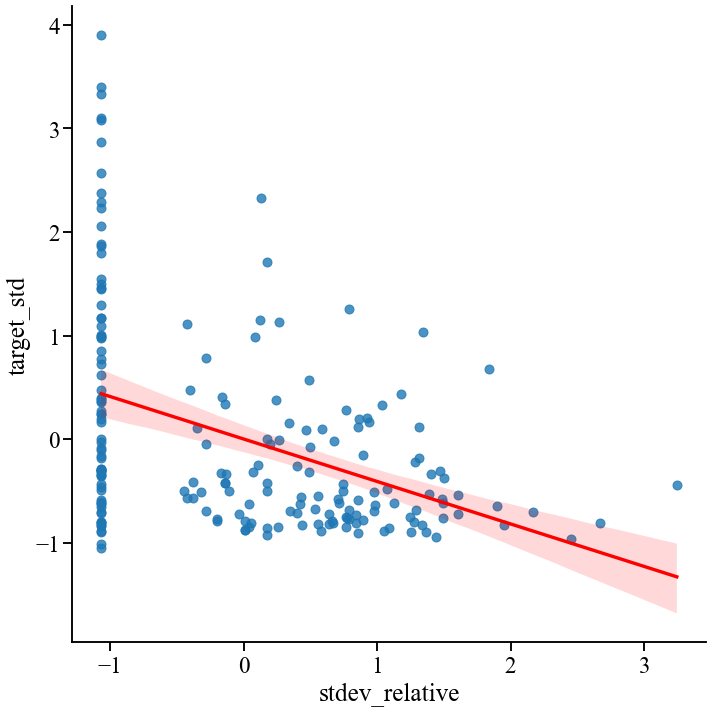

In [53]:
# look at some correlations
sns.lmplot(dat_model.conv, x = "stdev_relative", y = "target_std", line_kws={'color': 'red'}, height = 10)
plt.savefig('./figures/dat_stdev_relative_lmplot.svg')

### 75% Data

In [36]:
dat_model75 = ModelBuilder(dataset_names = ["dat"], output_dir = '../output/first_75/')
dat_model75.select_target(target=["efficiency"])
dat_model75.define_model(model_type = 'linear')
dat_model75.get_split_datasets(dat_model75.baseline_model, val_size = 0.2, test_size = None)

final_feature_metrics_train,final_feature_metrics_test=repeated_kfold_cv_simplelinear(dat_model75)
dat_train_metrics75=convert_metrics_dict_to_sorted_df(final_feature_metrics_train)
dat_test_metrics75=convert_metrics_dict_to_sorted_df(final_feature_metrics_test)

dat_test_metrics75.head(10)

Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done


,feature,r2,mae,mse,rmse
697,max_user_sum_time_diff,0.12638,0.72244,0.90319,0.94243
521,max_user_sum_present_tense,0.1199,0.72509,0.90523,0.94463
531,stdev_user_sum_relative,0.1169,0.72474,0.91564,0.94875
593,max_user_sum_verbs,0.11277,0.73065,0.91463,0.94922
392,sum_num_chars,0.11262,0.72756,0.9138,0.94872
391,sum_num_words,0.11252,0.72793,0.91349,0.94864
409,max_user_sum_num_words,0.11209,0.72634,0.91905,0.95062
607,stdev_user_sum_auxiliary_verbs,0.11192,0.72848,0.91709,0.95038
635,stdev_user_sum_first_person,0.11144,0.72516,0.9197,0.95079
641,max_user_sum_nltk_english_stopwords,0.11141,0.72648,0.92107,0.95136


In [37]:
dat_train_metrics75.head(10).to_csv('./top_features_from_simple_reg/dat75_top_10.csv')

In [69]:
dat_test_metrics75.head(10).to_csv('./top_features_from_simple_reg/validation/dat75_top_10.csv')

### 50% Data

In [38]:
dat_model50 = ModelBuilder(dataset_names = ["dat"], output_dir = '../output/first_50/')
dat_model50.select_target(target=["efficiency"])
dat_model50.define_model(model_type = 'linear')

dat_model50.get_split_datasets(dat_model50.baseline_model, val_size = 0.2, test_size = None)

final_feature_metrics_train,final_feature_metrics_test=repeated_kfold_cv_simplelinear(dat_model50)
dat_train_metrics50=convert_metrics_dict_to_sorted_df(final_feature_metrics_train)
dat_test_metrics50=convert_metrics_dict_to_sorted_df(final_feature_metrics_test)

dat_test_metrics50.head(10)

Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done


,feature,r2,mae,mse,rmse
697,max_user_sum_time_diff,0.12638,0.72244,0.90319,0.94243
288,stdev_textblob_polarity,0.12353,0.71225,0.90187,0.94208
521,max_user_sum_present_tense,0.1199,0.72509,0.90523,0.94463
531,stdev_user_sum_relative,0.1169,0.72474,0.91564,0.94875
593,max_user_sum_verbs,0.11277,0.73065,0.91463,0.94922
409,max_user_sum_num_words,0.11209,0.72634,0.91905,0.95062
607,stdev_user_sum_auxiliary_verbs,0.11192,0.72848,0.91709,0.95038
635,stdev_user_sum_first_person,0.11144,0.72516,0.9197,0.95079
641,max_user_sum_nltk_english_stopwords,0.11141,0.72648,0.92107,0.95136
391,sum_num_words,0.11094,0.73126,0.91729,0.95021


In [39]:
dat_train_metrics50.head(10).to_csv('./top_features_from_simple_reg/dat50_top_10.csv')

In [70]:
dat_test_metrics50.head(10).to_csv('./top_features_from_simple_reg/validation/dat50_top_10.csv')

### 25% Data

In [40]:
dat_model25 = ModelBuilder(dataset_names = ["dat"], output_dir = '../output/first_25/')
dat_model25.select_target(target=["efficiency"])
dat_model25.define_model(model_type = 'linear')

dat_model25.get_split_datasets(dat_model25.baseline_model, val_size = 0.2, test_size = None)

final_feature_metrics_train,final_feature_metrics_test=repeated_kfold_cv_simplelinear(dat_model25)
dat_train_metrics25=convert_metrics_dict_to_sorted_df(final_feature_metrics_train)
dat_test_metrics25=convert_metrics_dict_to_sorted_df(final_feature_metrics_test)

dat_test_metrics25.head(10)

Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done


,feature,r2,mae,mse,rmse
697,max_user_sum_time_diff,0.12638,0.72244,0.90319,0.94243
521,max_user_sum_present_tense,0.1199,0.72509,0.90523,0.94463
531,stdev_user_sum_relative,0.1169,0.72474,0.91564,0.94875
593,max_user_sum_verbs,0.11277,0.73065,0.91463,0.94922
409,max_user_sum_num_words,0.11209,0.72634,0.91905,0.95062
607,stdev_user_sum_auxiliary_verbs,0.11192,0.72848,0.91709,0.95038
635,stdev_user_sum_first_person,0.11144,0.72516,0.9197,0.95079
641,max_user_sum_nltk_english_stopwords,0.11141,0.72648,0.92107,0.95136
398,average_user_sum_negative_bert,0.11045,0.71399,0.92082,0.95162
533,max_user_sum_relative,0.11015,0.72915,0.92284,0.95237


In [41]:
dat_train_metrics25.head(10).to_csv('./top_features_from_simple_reg/dat25_top_10.csv')

In [71]:
dat_test_metrics25.head(10).to_csv('./top_features_from_simple_reg/validation/dat25_top_10.csv')

# Estimation

### Full Data (100%)

In [42]:
estimation_blended_model = ModelBuilder(dataset_names = ["gurcay", "becker"])
estimation_blended_model.select_target(target=["reverse_mean_post_discussion_error_pct", "reverse_mean_post_discussion_error_pct"])
estimation_blended_model.define_model(model_type = 'linear')

estimation_blended_model.get_split_datasets(estimation_blended_model.baseline_model, val_size = 0.2, test_size = None)

final_feature_metrics_train,final_feature_metrics_test=repeated_kfold_cv_simplelinear(estimation_blended_model)
estimation_blended_train_metrics=convert_metrics_dict_to_sorted_df(final_feature_metrics_train)
estimation_blended_test_metrics=convert_metrics_dict_to_sorted_df(final_feature_metrics_test)

estimation_blended_test_metrics.head(10)

Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done


,feature,r2,mae,mse,rmse
148,stdev_inhibition,-0.0563,0.3307,0.6227,0.7891
1142,average_user_avg_haspositive,-0.072025,0.296375,0.409925,0.633375
442,average_user_sum_inclusive,-0.0758,0.3087,0.47935,0.68385
945,max_user_avg_money,-0.07685,0.29415,0.4919,0.69425
863,stdev_user_avg_health,-0.0821,0.3309,0.6379,0.7987
710,average_user_sum_factuality,-0.0826,0.3322,0.6383,0.7989
1047,stdev_user_avg_content_word_accommodation,-0.0832,0.31055,0.49615,0.6968
328,stdev_deference,-0.0856,0.2971,0.3308,0.5752
1046,average_user_avg_content_word_accommodation,-0.0858,0.2726,0.3539,0.5949
50,max_conjunction,-0.0888,0.262,0.3549,0.5957


In [43]:
estimation_blended_train_metrics.head(10).to_csv('./top_features_from_simple_reg/estimation_top_10.csv')

In [72]:
estimation_blended_test_metrics.head(10).to_csv('./top_features_from_simple_reg/validation/estimation_top_10.csv')

In [73]:
get_heteroskedasticity_test(estimation_blended_model.conv["stdev_inhibition"], estimation_blended_model.conv["target_std"])

{'Test Statistic': 1.745106079255387,
 'Test Statistic p-value': 0.41788331354459796,
 'F-Statistic': 0.8629695419990023,
 'F-Test p-value': 0.4246688973620718}

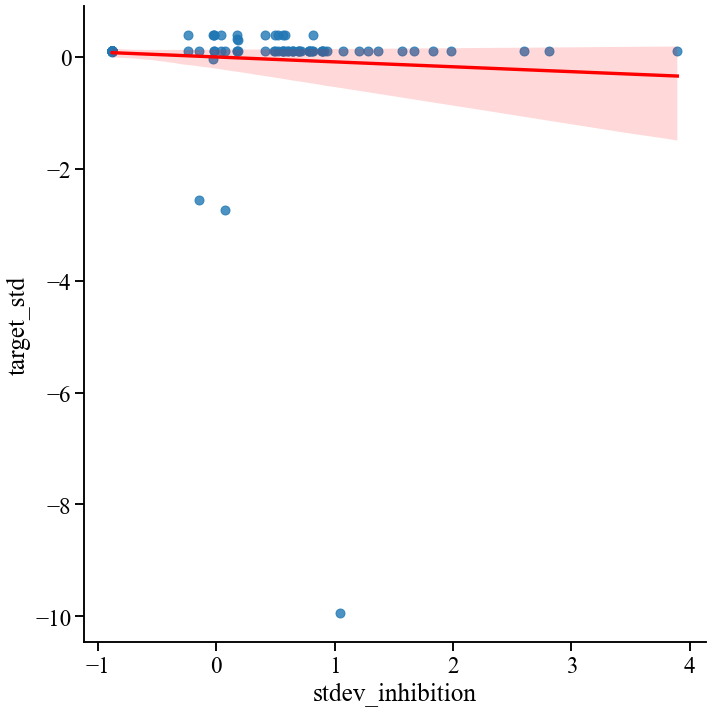

In [55]:
# look at some correlations
sns.lmplot(estimation_blended_model.conv, x = "stdev_inhibition", y = "target_std", line_kws={'color': 'red'}, height = 10)
plt.savefig('./figures/estimation_stdev_inhibition_lmplot.svg')

### 75% Data

In [46]:
estimation_blended_model75 = ModelBuilder(dataset_names = ["gurcay", "becker"],  output_dir = '../output/first_75/')
estimation_blended_model75.select_target(target=["reverse_mean_post_discussion_error_pct", "reverse_mean_post_discussion_error_pct"])
estimation_blended_model75.define_model(model_type = 'linear')

estimation_blended_model75.get_split_datasets(estimation_blended_model75.baseline_model, val_size = 0.2, test_size = None)

final_feature_metrics_train,final_feature_metrics_test=repeated_kfold_cv_simplelinear(estimation_blended_model75)
estimation_blended_train_metrics75=convert_metrics_dict_to_sorted_df(final_feature_metrics_train)
estimation_blended_test_metrics75=convert_metrics_dict_to_sorted_df(final_feature_metrics_test)

estimation_blended_test_metrics75.head(10)

Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done


,feature,r2,mae,mse,rmse
1142,average_user_avg_haspositive,-0.072025,0.296375,0.409925,0.633375
442,average_user_sum_inclusive,-0.0758,0.3087,0.47935,0.68385
945,max_user_avg_money,-0.07685,0.29415,0.4919,0.69425
863,stdev_user_avg_health,-0.0821,0.3309,0.6379,0.7987
710,average_user_sum_factuality,-0.0826,0.3322,0.6383,0.7989
1047,stdev_user_avg_content_word_accommodation,-0.0832,0.31055,0.49615,0.6968
1046,average_user_avg_content_word_accommodation,-0.0858,0.2726,0.3539,0.5949
67,average_adverbs,-0.0873,0.3458,0.641,0.8006
471,stdev_user_sum_swear,-0.0891,0.3556,0.6421,0.8013
990,average_user_avg_cognitive_mech,-0.090233,0.312533,0.438567,0.6534


In [47]:
estimation_blended_train_metrics75.head(10).to_csv('./top_features_from_simple_reg/estimation75_top_10.csv')

In [74]:
estimation_blended_test_metrics75.head(10).to_csv('./top_features_from_simple_reg/validation/estimation75_top_10.csv')

### 50% Data

In [48]:
estimation_blended_model50 = ModelBuilder(dataset_names = ["gurcay", "becker"],  output_dir = '../output/first_50/')
estimation_blended_model50.select_target(target=["reverse_mean_post_discussion_error_pct", "reverse_mean_post_discussion_error_pct"])
estimation_blended_model50.define_model(model_type = 'linear')

estimation_blended_model50.get_split_datasets(estimation_blended_model50.baseline_model, val_size = 0.2, test_size = None)

final_feature_metrics_train,final_feature_metrics_test=repeated_kfold_cv_simplelinear(estimation_blended_model50)
estimation_blended_train_metrics50=convert_metrics_dict_to_sorted_df(final_feature_metrics_train)
estimation_blended_test_metrics50=convert_metrics_dict_to_sorted_df(final_feature_metrics_test)

estimation_blended_test_metrics50.head(10)

Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done


,feature,r2,mae,mse,rmse
80,stdev_negation,-0.0637,0.284,0.3242,0.5694
274,max_function_word_accommodation,-0.0693,0.3501,0.6304,0.794
1142,average_user_avg_haspositive,-0.072025,0.296375,0.409925,0.633375
64,stdev_achievement,-0.0753,0.3474,0.6339,0.7962
442,average_user_sum_inclusive,-0.0758,0.3087,0.47935,0.68385
945,max_user_avg_money,-0.07685,0.29415,0.4919,0.69425
863,stdev_user_avg_health,-0.0821,0.3309,0.6379,0.7987
710,average_user_sum_factuality,-0.0826,0.3322,0.6383,0.7989
1047,stdev_user_avg_content_word_accommodation,-0.0832,0.31055,0.49615,0.6968
1046,average_user_avg_content_word_accommodation,-0.0858,0.2726,0.3539,0.5949


In [49]:
estimation_blended_train_metrics50.head(10).to_csv('./top_features_from_simple_reg/estimation50_top_10.csv')

In [75]:
estimation_blended_test_metrics50.head(10).to_csv('./top_features_from_simple_reg/validation/estimation50_top_10.csv')

### 25% Data

In [50]:
estimation_blended_model25 = ModelBuilder(dataset_names = ["gurcay", "becker"],  output_dir = '../output/first_25/')
estimation_blended_model25.select_target(target=["reverse_mean_post_discussion_error_pct", "reverse_mean_post_discussion_error_pct"])
estimation_blended_model25.define_model(model_type = 'linear')

estimation_blended_model25.get_split_datasets(estimation_blended_model25.baseline_model, val_size = 0.2, test_size = None)

final_feature_metrics_train,final_feature_metrics_test=repeated_kfold_cv_simplelinear(estimation_blended_model25)
estimation_blended_train_metrics25=convert_metrics_dict_to_sorted_df(final_feature_metrics_train)
estimation_blended_test_metrics25=convert_metrics_dict_to_sorted_df(final_feature_metrics_test)

estimation_blended_test_metrics25.head(10)

Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done


,feature,r2,mae,mse,rmse
242,max_positive_words,-0.0666,0.2478,0.3476,0.5896
132,stdev_future_tense,-0.0688,0.28875,0.4901,0.6923
1142,average_user_avg_haspositive,-0.072025,0.296375,0.409925,0.633375
442,average_user_sum_inclusive,-0.0758,0.3087,0.47935,0.68385
945,max_user_avg_money,-0.07685,0.29415,0.4919,0.69425
863,stdev_user_avg_health,-0.0821,0.3309,0.6379,0.7987
710,average_user_sum_factuality,-0.0826,0.3322,0.6383,0.7989
1047,stdev_user_avg_content_word_accommodation,-0.0832,0.31055,0.49615,0.6968
1046,average_user_avg_content_word_accommodation,-0.0858,0.2726,0.3539,0.5949
302,max_dale_chall_score,-0.0861,0.256,0.354,0.595


In [51]:
estimation_blended_train_metrics25.head(10).to_csv('./top_features_from_simple_reg/estimation25_top_10.csv')

In [76]:
estimation_blended_test_metrics25.head(10).to_csv('./top_features_from_simple_reg/validation/estimation25_top_10.csv')